In [1]:
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [2]:
# set number of assets (= number of qubits)
num_assets = 12
seed = 123

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

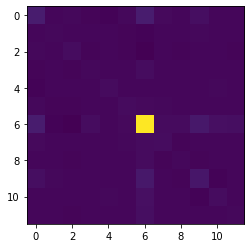

In [3]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [4]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.015284386652 x_0 + 0.000780952145 x_1 - 0.000517920547 x_2
      - 0.000870005837 x_3 - 0.010323519990 x_4 + 0.001666841256 x_5
      - 0.027213819622 x_6 - 0.000348237886 x_7 + 0.001120764278 x_8
      + 0.012440342693 x_9 - 0.001609199513 x_10 - 0.003794418593 x_11 + [
      0.002541388592 x_0^2 + 0.000146804433 x_0*x_1 + 0.000257201062 x_0*x_2
      - 0.000199722426 x_0*x_3 - 0.000626398406 x_0*x_4 + 0.000478782112 x_0*x_5
      + 0.005160155269 x_0*x_6 + 0.000564541457 x_0*x_7 - 0.000049255458 x_0*x_8
      + 0.001754659006 x_0*x_9 - 0.000083775278 x_0*x_10
      + 0.000164466673 x_0*x_11 + 0.000258486713 x_1^2 + 0.000106085519 x_1*x_2
      + 0.000088963242 x_1*x_3 - 0.000026490315 x_1*x_4 - 0.000159895987 x_1*x_5
      - 0.000517341706 x_1*x_6 - 0.000034553283 x_1*x_7 + 0.000146005788 x_1*x_8
      + 0.000255384882 x_1*x_9 + 0.000067312766 x_1*x_10
      - 0.0

In [5]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [8]:
%%time
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1.], value -0.0286

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 0 1 0 1 1 0 1 1]	-0.0150		0.4786
[0 1 1 1 1 0 1 0 0 1 0 0]	0.0000		0.4754
[1 1 0 1 1 0 0 0 1 0 1 0]	-0.0240		0.0167
[0 0 1 0 0 1 1 1 0 1 0 1]	0.0092		0.0132
[0 1 1 0 0 1 1 0 0 1 0 1]	0.0090		0.0038
[1 1 0 0 0 1 0 1 1 0 1 1]	1.1029		0.0010
[1 1 0 1 1 0 0 1 1 0 1 0]	1.0934		0.0010
[1 0 0 1 1 0 0 1 1 0 1 0]	-0.0248		0.0008
[0 0 1 1 1 0 1 0 0 1 0 0]	1.1162		0.0008
[1 0 0 1 1 0 0 0 1 0 1 0]	1.0919		0.0005
[1 0 0 0 0 1 0 1 1 0 0 1]	1.1032		0.0005
[1 0 1 0 0 1 0 1 1 0 1 1]	1.1017		0.0004
[1 1 0 1 1 0 0 1 0 0 1 0]	-0.0249		0.0004
[0 0 1 0 0 1 1 0 0 1 0 1]	1.1253		0.0004
[1 1 0 0 1 0 0 1 1 0 1 0]	-0.0230		0.0003
[0 0 1 1 0 1 1 1 0 1 0 1]	1.1261		0.0003
[1 1 0 1 1 0 0 1 1 0 1 1]	4.4409		0.0003
[1 1 0 1 0 0 0 1 1 0 1 0]	-0.0135		0.0003
[0 0 1 0 1 1 1 0 0 1 0 1]	-0.0014		0.0003
[1 1 0 1

[0 1 0 1 1 0 1 1 0 1 0 0]	0.0015		0.0000
[0 1 1 1 1 1 1 0 0 1 0 1]	4.4674		0.0000
[1 0 0 0 1 0 0 1 1 0 0 0]	4.4452		0.0000
[1 0 0 0 1 0 0 1 1 1 1 0]	-0.0101		0.0000
[0 0 1 0 1 1 1 0 0 0 0 1]	1.1001		0.0000
[1 0 0 0 0 0 0 1 1 0 1 0]	4.4542		0.0000
[1 1 1 1 0 0 0 1 1 0 1 0]	1.1034		0.0000
[0 0 1 0 0 1 0 0 1 1 0 1]	1.1293		0.0000
[0 1 1 0 1 0 1 0 0 1 0 1]	-0.0029		0.0000
[0 1 1 1 1 1 1 1 0 1 0 1]	10.0533		0.0000
[0 0 1 0 0 1 1 1 1 0 0 1]	-0.0048		0.0000
[1 1 0 0 1 0 1 1 1 0 1 0]	1.0930		0.0000
[1 0 1 0 0 1 0 0 0 1 0 1]	1.1156		0.0000
[0 0 0 0 0 1 1 1 1 1 0 1]	0.0118		0.0000
[1 1 1 1 0 1 1 0 0 1 0 1]	4.4669		0.0000
[1 0 1 0 0 1 1 1 0 1 0 0]	0.0020		0.0000
[1 0 0 0 0 1 1 0 0 1 0 1]	1.1162		0.0000
[1 1 1 1 1 0 0 1 1 0 0 0]	1.0943		0.0000
[0 0 1 0 0 1 1 1 1 1 1 1]	4.4783		0.0000
[0 0 1 0 1 1 1 0 0 1 1 1]	1.1152		0.0000
[1 1 0 1 0 1 0 1 1 0 1 1]	4.4532		0.0000
[0 1 0 1 1 1 0 1 1 0 1 0]	1.1096		0.0000
[0 0 0 1 1 0 1 0 0 1 0 0]	4.4682		0.0000
[1 1 0 1 1 0 0 0 1 0 0 1]	-0.0264		0.0000
[1 1 0 1 0 

[1 0 1 0 0 1 0 1 1 1 1 1]	4.4667		0.0000
[1 1 0 1 1 1 0 0 1 0 0 0]	-0.0207		0.0000
[1 1 1 1 1 0 1 1 0 1 1 0]	10.0431		0.0000
[1 0 0 0 1 1 0 1 1 0 0 1]	-0.0239		0.0000
[0 1 0 0 0 1 1 0 1 1 0 1]	0.0119		0.0000
[0 0 1 1 1 0 1 1 0 1 0 1]	1.1141		0.0000
[1 1 1 1 1 0 1 0 1 0 1 0]	4.4424		0.0000
[0 0 0 1 1 1 0 1 1 0 1 0]	-0.0083		0.0000
[0 1 1 0 0 1 1 1 1 1 0 0]	1.1313		0.0000
[1 0 0 1 0 0 0 0 1 0 1 1]	1.0985		0.0000
[1 1 0 1 0 1 0 1 1 0 1 0]	1.1058		0.0000
[0 1 1 1 1 0 1 1 1 1 1 0]	10.0552		0.0000
[1 0 0 1 1 0 0 1 1 1 1 1]	4.4538		0.0000
[1 1 1 1 1 1 0 0 1 0 1 0]	4.4460		0.0000
[0 0 1 0 1 0 1 1 0 1 0 1]	-0.0029		0.0000
[0 0 1 0 0 1 0 1 1 0 1 1]	-0.0019		0.0000
[0 1 1 1 1 0 1 1 1 0 0 0]	1.1036		0.0000
[1 1 1 1 1 0 1 1 0 0 0 0]	1.0905		0.0000
[1 0 1 1 0 0 0 1 1 0 1 0]	-0.0148		0.0000
[0 1 1 1 1 0 0 0 0 1 0 1]	-0.0000		0.0000
[0 0 1 0 0 0 0 0 0 1 0 1]	10.0627		0.0000
[1 0 0 1 0 1 0 1 1 1 1 1]	4.4661		0.0000
[1 0 1 0 1 1 0 0 1 0 1 1]	1.0911		0.0000
[0 1 1 1 0 1 1 1 0 1 0 0]	1.1296		0.0000
[0 0 0

[1 1 0 0 0 0 0 1 0 0 1 0]	4.4541		0.0000
[0 0 1 1 1 0 1 1 0 0 0 0]	1.1012		0.0000
[1 1 1 0 0 1 1 0 0 1 1 1]	4.4665		0.0000
[0 1 0 0 0 1 0 0 0 1 0 1]	4.4806		0.0000
[1 0 1 0 0 1 0 0 0 0 1 1]	1.1001		0.0000
[0 0 1 1 0 1 1 1 0 0 0 0]	1.1132		0.0000
[0 1 1 0 0 1 1 1 0 1 1 0]	1.1293		0.0000
[0 0 0 1 0 1 1 1 0 1 0 0]	1.1299		0.0000
[1 1 1 0 0 1 1 1 0 1 0 1]	4.4681		0.0000
[1 1 0 1 1 0 0 0 1 1 0 0]	-0.0084		0.0000
[1 0 1 1 0 1 1 1 0 0 0 1]	1.0996		0.0000
[0 0 0 1 0 1 1 0 0 0 0 1]	4.4620		0.0000
[1 0 1 0 0 1 0 0 1 0 1 0]	1.1049		0.0000
[0 0 0 0 0 0 0 1 1 0 1 1]	4.4644		0.0000
[0 0 1 1 0 1 1 1 0 1 1 0]	1.1285		0.0000
[1 1 0 0 1 1 0 0 0 0 1 0]	1.0947		0.0000
[1 0 1 1 0 1 1 1 0 1 1 1]	10.0518		0.0000
[0 1 1 0 0 1 0 1 0 0 0 1]	1.1159		0.0000
[1 0 1 0 1 1 1 0 1 1 0 1]	4.4578		0.0000
[0 1 0 0 0 0 0 1 1 0 1 0]	4.4690		0.0000
[0 0 0 1 0 1 1 0 0 1 1 1]	0.0089		0.0000
[1 0 0 1 1 1 0 1 1 1 1 0]	4.4597		0.0000
[1 0 1 1 1 0 1 1 0 1 0 0]	1.1063		0.0000
[0 0 1 1 0 1 1 0 0 0 0 0]	4.4636		0.0000
[1 0 1 0 0 0 1

[1 1 0 1 0 1 0 1 1 0 0 1]	1.1033		0.0000
[0 0 0 0 0 1 1 1 1 1 0 0]	1.1315		0.0000
[1 1 0 0 0 0 0 1 1 0 0 1]	1.1018		0.0000
[0 0 1 1 1 1 0 1 0 1 0 1]	1.1181		0.0000
[0 0 1 0 1 0 1 0 0 0 0 0]	10.0368		0.0000
[1 1 1 0 1 1 1 0 0 1 0 0]	1.1087		0.0000
[1 1 0 0 1 1 0 0 1 1 1 0]	1.1099		0.0000
[0 0 0 1 0 1 0 0 0 1 0 1]	4.4789		0.0000
[1 1 0 1 1 1 0 1 0 0 1 1]	4.4420		0.0000
[0 1 1 1 0 1 1 1 1 1 0 0]	4.4823		0.0000
[1 1 1 1 1 0 1 0 0 0 0 1]	1.0869		0.0000
[1 0 0 0 1 0 0 1 1 1 1 1]	1.1034		0.0000
[0 1 0 1 0 1 1 0 0 1 0 0]	1.1299		0.0000
[1 1 0 0 0 1 1 1 1 0 0 1]	1.1032		0.0000
[0 0 1 1 0 1 0 1 0 1 1 1]	1.1264		0.0000
[0 1 1 0 1 0 0 1 0 1 0 0]	1.1216		0.0000
[0 1 1 1 1 0 1 0 1 0 1 0]	1.1031		0.0000
[0 1 1 0 0 0 0 1 0 1 0 1]	1.1278		0.0000
[0 1 1 0 1 1 1 0 1 1 0 0]	1.1207		0.0000
[0 0 1 0 0 1 1 0 1 0 1 1]	-0.0056		0.0000
[1 0 1 0 0 1 1 1 0 0 0 0]	1.1026		0.0000
[1 0 1 1 0 0 1 0 0 1 0 0]	1.1155		0.0000
[0 1 0 1 0 1 1 0 1 1 0 1]	1.1290		0.0000
[1 0 1 1 1 1 1 0 0 1 0 0]	1.1077		0.0000
[1 1 1 1 1 1 0

[1 1 0 1 1 0 1 0 0 0 1 1]	1.0877		0.0000
[1 0 0 0 1 1 0 1 0 0 0 1]	1.0919		0.0000
[0 1 1 0 0 0 1 0 1 1 0 0]	1.1285		0.0000
[1 0 1 0 1 1 0 1 0 0 1 1]	1.0907		0.0000
[1 0 1 0 1 0 1 0 0 1 0 1]	-0.0143		0.0000
[0 0 0 0 1 0 0 0 1 0 0 0]	17.8634		0.0000
[0 1 0 1 0 0 1 0 0 0 0 0]	10.0483		0.0000
[0 1 1 1 0 1 1 1 1 1 1 1]	17.8833		0.0000
[0 0 1 0 0 0 1 0 0 1 1 1]	1.1227		0.0000
[0 0 0 0 0 1 0 1 0 0 1 1]	4.4654		0.0000
[0 0 0 1 0 0 1 0 0 1 0 1]	4.4752		0.0000
[1 1 0 1 1 1 0 1 1 1 1 1]	17.8616		0.0000
[0 1 1 0 0 1 1 0 1 0 0 1]	-0.0048		0.0000
[0 0 0 0 1 1 0 0 1 0 1 0]	4.4602		0.0000
[0 1 0 1 1 0 0 1 1 1 0 0]	0.0051		0.0000
[1 0 0 0 1 1 1 1 1 0 0 1]	1.0926		0.0000
[0 0 1 1 1 0 1 0 1 0 0 0]	1.1023		0.0000
[0 0 0 0 0 1 1 1 0 0 0 0]	10.0506		0.0000
[0 1 0 1 1 0 1 1 1 0 1 1]	4.4529		0.0000
[1 1 0 1 0 1 0 1 1 0 0 0]	-0.0101		0.0000
[1 0 1 0 1 1 1 1 0 1 1 1]	10.0422		0.0000
[1 0 0 0 0 0 0 0 1 1 1 1]	1.1131		0.0000
[0 1 1 1 0 1 1 0 0 1 1 0]	1.1284		0.0000
[1 0 1 0 0 1 0 1 0 1 1 1]	1.1147		0.0000
[1 0 0 

[0 0 1 1 0 0 1 1 1 1 0 0]	0.0111		0.0000
[0 0 1 1 0 0 1 1 0 0 0 1]	1.1081		0.0000
[1 0 0 0 1 0 1 0 1 0 0 0]	4.4426		0.0000
[1 0 1 1 0 1 1 0 1 1 0 0]	1.1194		0.0000
[1 0 1 0 0 0 0 0 0 1 0 1]	4.4647		0.0000
[0 1 0 1 1 0 0 0 0 0 1 1]	1.1025		0.0000
[1 1 0 1 1 1 1 1 0 0 1 0]	4.4450		0.0000
[0 0 1 1 1 0 1 0 1 1 0 1]	1.1150		0.0000
[0 0 0 1 0 0 0 0 1 0 1 1]	4.4636		0.0000
[1 1 0 1 1 1 0 1 0 0 0 0]	-0.0215		0.0000
[0 0 0 1 1 0 0 0 1 0 0 1]	4.4550		0.0000
[0 0 0 1 1 1 0 1 1 0 1 1]	1.1051		0.0000
[0 0 1 0 1 0 1 0 0 0 0 1]	4.4489		0.0000
[1 1 0 0 0 0 0 0 0 0 1 1]	4.4501		0.0000
[0 0 1 0 0 1 0 1 1 1 0 0]	1.1333		0.0000
[0 0 1 1 1 0 1 1 1 0 0 0]	-0.0142		0.0000
[0 0 1 1 0 0 1 1 0 1 1 1]	1.1234		0.0000
[1 0 1 0 1 0 1 1 0 1 0 1]	1.1038		0.0000
[1 0 1 0 1 1 0 1 1 0 0 1]	1.0927		0.0000
[1 1 1 1 1 0 0 1 0 0 0 0]	-0.0238		0.0000
[0 0 0 1 0 1 0 1 0 1 0 1]	1.1281		0.0000
[1 1 0 1 1 1 0 1 1 1 0 0]	4.4622		0.0000
[1 0 0 0 0 0 1 0 1 0 1 0]	4.4525		0.0000
[0 1 1 1 1 0 0 1 1 0 0 0]	-0.0087		0.0000
[1 1 1 0 0 1

[0 0 0 0 1 1 1 0 0 1 1 1]	-0.0008		0.0000
[0 0 1 1 1 1 0 1 1 0 1 0]	1.1083		0.0000
[0 1 1 1 0 0 1 1 1 1 1 0]	4.4797		0.0000
[0 1 0 1 1 0 0 0 0 0 0 0]	10.0434		0.0000
[1 0 1 1 0 0 0 0 1 0 1 1]	-0.0188		0.0000
[0 0 1 1 1 0 0 1 1 1 1 0]	1.1194		0.0000
[1 1 0 1 0 0 0 0 0 1 1 0]	1.1160		0.0000
[0 1 1 1 0 0 1 1 1 1 0 1]	4.4773		0.0000
[0 1 1 0 0 1 1 0 1 0 0 0]	1.1151		0.0000
[1 0 1 1 0 1 1 0 1 1 1 1]	10.0523		0.0000
[0 0 0 0 1 1 1 0 0 1 0 0]	4.4704		0.0000
[0 0 0 0 0 1 0 0 1 0 1 0]	10.0551		0.0000
[1 1 1 0 0 0 1 1 0 1 0 0]	0.0004		0.0000
[0 1 0 0 0 0 0 1 1 0 0 0]	10.0553		0.0000
[0 1 0 0 0 1 1 1 1 0 0 1]	-0.0030		0.0000
[0 0 1 1 1 0 1 0 1 1 1 0]	1.1174		0.0000
[0 1 1 0 0 1 1 0 1 1 1 0]	1.1301		0.0000
[0 0 0 1 1 0 0 0 0 1 1 0]	4.4693		0.0000
[1 0 1 1 0 1 0 1 0 0 1 1]	1.0997		0.0000
[0 1 1 0 1 1 1 1 1 1 1 1]	17.8737		0.0000
[0 0 0 1 1 0 1 1 0 0 1 0]	1.1021		0.0000
[1 1 1 1 1 1 0 0 0 1 0 0]	1.1093		0.0000
[1 0 1 1 1 1 1 0 0 1 1 1]	10.0409		0.0000
[0 1 1 0 1 0 0 0 0 0 1 0]	4.4578		0.0000
[1 1 1 

[1 0 0 1 1 0 1 1 0 0 1 1]	1.0879		0.0000
[1 1 0 0 0 1 0 0 0 0 1 0]	4.4559		0.0000
[0 1 0 0 0 1 0 0 1 1 0 1]	1.1307		0.0000
[1 1 0 1 1 0 1 0 0 1 1 0]	1.1065		0.0000
[0 0 0 1 0 1 1 0 0 0 0 0]	10.0499		0.0000
[0 0 1 1 1 0 0 0 1 0 0 0]	4.4582		0.0000
[1 1 0 1 0 0 1 1 1 1 1 0]	4.4702		0.0000
[1 0 0 1 0 0 0 0 1 1 1 1]	-0.0047		0.0000
[1 1 0 1 1 0 1 0 1 1 0 0]	1.1088		0.0000
[1 0 0 1 0 0 0 1 1 0 0 1]	1.1000		0.0000
[0 1 0 0 1 1 1 0 0 0 0 1]	1.1017		0.0000
[0 1 1 0 0 0 1 1 0 0 0 1]	1.1089		0.0000
[0 0 1 0 0 0 0 1 0 1 0 0]	10.0666		0.0000
[1 1 1 0 0 1 0 1 0 1 1 1]	4.4668		0.0000
[0 1 1 0 1 1 0 1 1 0 1 0]	1.1100		0.0000
[1 1 0 1 1 1 0 0 1 1 0 0]	1.1107		0.0000
[0 0 0 1 0 1 1 1 1 1 1 1]	4.4795		0.0000
[1 0 0 1 0 0 0 1 1 1 0 0]	1.1179		0.0000
[0 0 1 1 1 1 0 0 1 0 1 0]	-0.0090		0.0000
[0 0 0 1 1 0 1 0 1 0 1 1]	-0.0164		0.0000
[0 1 1 0 1 0 0 1 1 1 1 0]	1.1213		0.0000
[0 1 0 0 1 0 1 1 0 0 1 0]	1.1026		0.0000
[0 0 0 1 0 1 1 0 0 1 1 0]	1.1287		0.0000
[1 0 0 1 0 1 0 0 1 0 0 0]	4.4566		0.0000
[1 0 1 1 0 

[0 0 1 1 1 1 0 1 1 1 0 1]	4.4701		0.0000
[1 0 1 0 1 1 1 0 1 1 0 0]	1.1094		0.0000
[1 1 1 0 1 0 0 0 0 0 0 0]	4.4447		0.0000
[1 0 0 1 0 0 0 0 0 1 1 0]	4.4658		0.0000
[1 0 0 1 0 1 1 1 1 1 1 1]	10.0545		0.0000
[1 0 0 0 0 1 1 1 1 1 1 0]	1.1209		0.0000
[0 0 1 1 0 1 0 0 0 1 1 0]	1.1297		0.0000
[1 1 0 0 1 0 1 1 0 0 1 1]	1.0886		0.0000
[0 1 1 0 1 0 0 1 0 1 1 0]	0.0033		0.0000
[0 0 0 0 1 1 1 1 0 1 0 0]	1.1201		0.0000
[1 0 0 0 1 1 1 0 1 0 1 1]	1.0915		0.0000
[0 0 0 1 0 0 0 0 0 0 1 0]	17.8702		0.0000
[0 1 1 0 1 1 0 0 1 0 1 0]	-0.0073		0.0000
[0 1 1 1 0 0 0 1 0 1 0 1]	0.0099		0.0000
[1 1 1 0 0 0 1 0 0 0 0 1]	1.0972		0.0000
[1 0 1 1 1 0 1 1 0 0 1 0]	1.0898		0.0000
[1 1 0 1 0 1 0 0 1 1 1 1]	4.4667		0.0000
[1 0 0 0 1 0 0 1 0 1 1 1]	-0.0146		0.0000
[0 0 1 1 1 0 1 0 0 0 0 1]	1.0978		0.0000
[0 1 0 1 1 0 0 1 0 1 1 1]	1.1160		0.0000
[0 1 0 0 1 1 0 0 0 1 0 1]	1.1197		0.0000
[1 1 0 0 0 0 0 1 1 1 0 0]	1.1198		0.0000
[0 1 0 1 0 1 1 0 1 1 0 0]	0.0148		0.0000
[0 0 0 1 1 0 1 0 1 0 0 0]	4.4545		0.0000
[1 1 1 0 0 0

[1 1 1 0 0 0 0 1 1 0 0 1]	-0.0153		0.0000
[0 0 1 0 1 0 1 0 1 0 0 0]	4.4533		0.0000
[0 0 0 0 0 1 1 1 1 0 1 1]	-0.0037		0.0000
[0 1 1 0 1 1 0 1 0 1 0 0]	0.0065		0.0000
[0 1 0 0 1 1 1 1 1 0 1 0]	1.1070		0.0000
[1 0 0 0 1 1 1 1 1 0 1 0]	1.0951		0.0000
[1 0 1 0 1 1 1 0 0 0 0 0]	1.0915		0.0000
[1 0 1 0 0 1 0 0 1 1 0 0]	1.1202		0.0000
[1 0 0 1 1 0 1 0 0 1 1 0]	-0.0114		0.0000
[1 1 1 1 1 0 0 0 0 1 1 1]	4.4533		0.0000
[0 1 1 0 1 1 0 0 0 1 1 1]	1.1180		0.0000
[0 0 1 1 1 1 0 0 0 1 1 1]	1.1164		0.0000
[0 0 1 1 0 1 0 1 1 0 0 1]	-0.0018		0.0000
[0 0 0 1 1 1 1 0 1 1 0 1]	1.1186		0.0000
[1 1 0 0 0 0 0 0 0 1 1 0]	4.4677		0.0000
[0 0 1 1 1 0 1 0 1 0 1 0]	-0.0148		0.0000
[1 0 1 0 1 0 1 0 0 0 0 0]	4.4401		0.0000
[1 0 0 1 1 1 1 1 1 1 1 0]	10.0472		0.0000
[0 0 1 1 0 0 1 0 0 0 1 0]	4.4613		0.0000
[0 0 0 1 0 0 1 1 1 1 0 1]	0.0094		0.0000
[0 0 1 0 0 1 1 1 1 0 1 0]	-0.0020		0.0000
[0 1 1 1 1 0 0 1 1 1 1 1]	10.0531		0.0000
[1 1 1 0 0 1 0 1 1 0 0 0]	-0.0095		0.0000
[1 0 1 1 1 0 1 0 1 0 0 0]	-0.0265		0.0000
[0 1 1

[1 1 0 1 1 0 1 0 0 1 1 1]	4.4550		0.0000
[0 0 0 0 0 0 0 0 1 0 0 0]	27.9266		0.0000
[0 1 0 1 0 1 1 1 1 1 1 1]	10.0653		0.0000
[1 0 1 0 1 0 0 1 0 1 1 0]	-0.0109		0.0000
[0 1 1 0 0 0 0 1 0 1 1 1]	0.0093		0.0000
[1 0 0 0 0 1 1 1 0 1 1 0]	0.0023		0.0000
[0 1 0 1 0 1 0 1 0 0 1 0]	1.1180		0.0000
[0 0 0 1 1 1 0 1 0 1 0 1]	0.0015		0.0000
[1 0 1 1 0 1 1 0 1 0 1 1]	4.4513		0.0000
[1 1 1 1 1 1 1 1 0 1 1 1]	27.9152		0.0000
[0 0 1 1 0 1 0 1 0 1 1 0]	0.0130		0.0000
[0 1 0 1 0 0 1 1 1 0 1 1]	1.1115		0.0000
[0 1 1 1 1 1 1 1 1 0 0 1]	10.0392		0.0000
[0 1 1 0 0 0 1 0 1 0 0 0]	4.4641		0.0000
[1 0 1 0 1 0 0 0 0 1 0 0]	4.4581		0.0000
[0 1 0 1 1 1 1 0 1 1 0 0]	1.1220		0.0000
[0 1 0 0 0 1 0 1 0 1 0 0]	4.4845		0.0000
[0 0 1 0 1 1 0 1 1 0 1 0]	-0.0080		0.0000
[0 1 0 0 0 0 1 1 0 0 0 1]	4.4608		0.0000
[0 1 1 1 1 1 0 0 1 1 0 1]	4.4709		0.0000
[0 1 1 1 1 1 1 1 0 0 1 0]	4.4553		0.0000
[0 1 1 1 1 0 0 1 0 0 0 1]	-0.0136		0.0000
[0 1 0 1 0 0 0 0 0 0 0 0]	17.8724		0.0000
[0 0 1 1 0 0 0 0 0 0 0 1]	10.0483		0.0000
[0 1 1 

[1 0 0 0 0 0 1 1 1 1 0 1]	-0.0009		0.0000
[0 0 0 0 0 0 1 0 1 1 0 0]	10.0647		0.0000
[1 0 0 0 1 0 1 0 0 1 0 0]	4.4571		0.0000
[0 1 0 0 0 1 0 0 1 0 1 0]	4.4709		0.0000
[0 0 1 0 1 0 1 0 1 0 0 1]	1.0995		0.0000
[1 1 0 1 0 1 0 1 0 1 1 0]	1.1186		0.0000
[1 0 1 0 1 1 1 1 1 1 0 0]	4.4615		0.0000
[1 0 0 0 1 1 0 1 1 1 0 0]	-0.0062		0.0000
[1 1 0 1 0 0 0 0 0 0 0 1]	4.4505		0.0000
[1 0 0 0 1 0 1 0 0 0 1 1]	1.0870		0.0000
[0 0 0 0 0 1 0 0 1 1 1 1]	1.1282		0.0000
[0 0 0 0 0 1 0 1 0 1 1 1]	1.1274		0.0000
[1 1 1 1 0 1 0 1 0 1 1 1]	10.0510		0.0000
[0 1 0 1 0 0 1 0 1 1 1 0]	0.0120		0.0000
[0 0 1 1 1 0 0 0 1 1 0 1]	-0.0001		0.0000
[1 1 1 1 0 0 1 1 1 0 1 1]	10.0356		0.0000
[0 0 0 0 0 0 1 1 1 0 1 0]	4.4645		0.0000
[1 1 1 0 0 0 0 1 1 1 1 1]	4.4657		0.0000
[1 0 1 0 1 0 1 0 0 1 1 1]	1.1023		0.0000
[0 0 0 0 1 0 0 1 0 1 1 0]	4.4701		0.0000
[0 1 1 1 0 1 0 1 1 1 1 1]	10.0646		0.0000
[1 0 1 0 1 1 0 1 0 1 0 0]	-0.0073		0.0000
[0 0 1 0 1 0 1 0 1 1 1 1]	1.1145		0.0000
[1 1 0 1 1 1 0 0 0 1 1 1]	4.4556		0.0000
[0 0 0 1

[0 1 0 0 1 1 1 0 0 1 1 0]	0.0026		0.0000
[1 0 0 1 0 1 0 0 0 1 1 1]	-0.0036		0.0000
[1 0 0 0 1 0 0 0 1 1 0 1]	1.1045		0.0000
[1 0 0 1 0 1 0 1 0 1 0 1]	-0.0015		0.0000
[1 0 1 1 0 0 0 0 0 0 1 1]	1.0971		0.0000
[1 0 0 0 0 0 0 0 1 1 1 0]	4.4677		0.0000
[1 0 0 0 1 1 1 0 1 0 0 1]	-0.0254		0.0000
[1 0 1 1 0 1 1 0 1 1 1 0]	4.4699		0.0000
[0 1 0 1 0 0 1 1 1 0 0 0]	1.1144		0.0000
[1 0 0 0 1 1 1 0 0 0 0 1]	1.0898		0.0000
[1 1 1 0 0 1 1 0 1 0 0 0]	-0.0129		0.0000
[0 1 1 0 1 1 1 0 1 0 1 1]	4.4535		0.0000
[0 0 1 1 1 0 0 1 1 1 1 1]	4.4668		0.0000
[0 0 0 0 1 1 1 1 1 1 0 0]	0.0048		0.0000
[1 0 1 1 0 0 0 1 0 0 1 1]	-0.0195		0.0000
[1 1 0 0 0 0 1 1 1 1 1 0]	1.1191		0.0000
[0 0 1 1 0 0 0 1 1 0 1 1]	-0.0048		0.0000
[1 0 1 1 1 0 0 0 0 1 0 1]	-0.0144		0.0000
[0 1 0 0 0 1 1 0 1 1 1 0]	0.0141		0.0000
[1 0 1 0 0 0 0 0 0 1 0 0]	10.0534		0.0000
[0 1 1 0 0 0 0 0 1 1 0 0]	4.4835		0.0000
[1 1 0 1 1 1 1 0 1 1 0 0]	4.4624		0.0000
[1 0 0 1 1 0 1 0 0 1 0 1]	-0.0135		0.0000
[1 0 1 0 1 0 1 1 1 1 1 0]	4.4585		0.0000
[0 1 1 

[1 1 1 0 0 1 0 0 0 1 1 0]	0.0018		0.0000
[0 0 1 1 0 1 1 0 1 0 1 0]	-0.0028		0.0000
[0 0 1 0 0 0 1 0 1 0 1 1]	1.1092		0.0000
[0 1 0 1 0 0 1 0 1 1 0 1]	0.0097		0.0000
[1 1 0 1 1 1 0 0 0 1 0 0]	-0.0075		0.0000
[0 1 1 0 0 1 0 0 1 1 1 0]	0.0156		0.0000
[1 1 0 0 0 1 0 1 0 0 0 0]	4.4575		0.0000
[0 0 0 1 1 1 0 0 0 0 1 1]	1.1036		0.0000
[0 0 0 1 0 1 1 0 1 0 0 0]	4.4667		0.0000
[0 1 0 1 1 0 1 0 0 0 1 1]	-0.0176		0.0000
[1 0 1 0 1 0 1 1 0 1 1 1]	4.4544		0.0000
[1 0 1 1 1 1 0 1 1 1 1 1]	17.8602		0.0000
[1 0 0 0 0 0 1 1 0 1 1 1]	-0.0031		0.0000
[0 1 0 1 1 1 1 1 1 1 0 1]	10.0562		0.0000
[1 0 1 0 0 0 0 1 1 1 0 1]	-0.0020		0.0000
[1 0 0 0 1 1 1 0 1 0 1 0]	-0.0230		0.0000
[0 1 1 1 0 0 0 0 0 0 0 1]	4.4642		0.0000
[1 0 1 1 0 0 0 1 0 1 1 0]	-0.0017		0.0000
[1 1 0 0 0 1 1 1 0 0 0 0]	1.1041		0.0000
[0 1 0 1 1 1 0 0 0 1 1 0]	0.0043		0.0000
[0 1 0 0 1 1 0 1 0 0 1 1]	-0.0116		0.0000
[1 0 0 1 1 1 0 1 0 0 0 1]	-0.0259		0.0000
[1 0 1 1 1 1 0 1 1 0 0 1]	4.4429		0.0000
[0 0 0 1 0 1 0 1 0 0 1 0]	4.4682		0.0000
[0 1 

[0 0 0 0 1 0 1 0 1 1 0 1]	1.1160		0.0000
[0 0 1 0 1 1 1 1 0 0 1 0]	-0.0133		0.0000
[0 0 1 1 1 1 0 0 1 1 0 0]	0.0054		0.0000
[0 0 0 0 1 1 1 0 1 0 1 0]	1.1056		0.0000
[0 0 1 0 0 0 0 0 0 0 1 1]	10.0480		0.0000
[1 1 1 1 0 1 1 1 1 0 1 0]	10.0409		0.0000
[0 1 0 0 1 0 1 1 0 1 0 1]	-0.0014		0.0000
[0 0 1 0 0 0 0 1 1 1 1 1]	0.0092		0.0000
[0 0 0 0 0 1 0 0 0 0 1 0]	17.8730		0.0000
[0 0 0 1 0 1 1 1 1 0 0 0]	1.1162		0.0000
[0 1 0 0 0 0 1 1 0 0 0 0]	10.0487		0.0000
[0 0 0 1 0 1 0 1 0 0 0 1]	4.4657		0.0000
[0 1 1 0 1 1 1 1 1 0 1 1]	10.0393		0.0000
[0 0 0 1 1 1 0 1 1 1 1 1]	4.4693		0.0000
[0 0 1 0 1 1 1 1 1 1 1 0]	4.4715		0.0000
[1 0 1 1 0 1 1 1 0 0 1 0]	1.1023		0.0000
[0 1 1 0 1 1 1 0 1 1 1 0]	4.4714		0.0000
[1 1 1 1 0 1 0 0 0 0 1 1]	1.1001		0.0000
[1 1 1 0 0 1 0 1 0 0 0 0]	1.1064		0.0000
[1 1 1 1 0 0 1 1 1 1 1 0]	10.0546		0.0000
[0 1 1 1 0 1 0 1 1 0 1 1]	4.4662		0.0000
[1 1 0 1 0 1 1 0 0 0 1 0]	-0.0141		0.0000
[1 0 0 0 1 1 0 0 0 0 0 1]	4.4424		0.0000
[1 1 0 1 1 1 1 1 0 0 1 1]	10.0275		0.0000
[1 0 1

[0 0 0 0 1 0 1 0 0 0 0 1]	10.0349		0.0000
[1 1 0 1 0 1 1 0 1 1 0 0]	1.1214		0.0000
[0 0 0 1 0 1 0 0 1 0 0 0]	10.0556		0.0000
[0 0 1 0 0 0 0 1 0 0 0 0]	17.8722		0.0000
[1 1 0 1 1 1 1 0 0 0 0 0]	-0.0240		0.0000
[1 0 1 1 1 0 1 1 0 1 1 1]	10.0395		0.0000
[0 0 0 0 1 0 0 0 0 1 0 0]	17.8756		0.0000
[0 1 0 1 0 1 1 1 1 0 1 0]	1.1168		0.0000
[0 1 0 1 0 0 0 1 0 0 0 1]	4.4645		0.0000
[1 0 1 1 0 0 0 1 1 1 0 0]	0.0008		0.0000
[1 0 1 1 0 1 1 1 1 0 1 0]	4.4550		0.0000
[0 0 0 1 0 1 0 0 0 0 1 0]	10.0531		0.0000
[0 0 1 0 1 0 0 0 0 0 0 1]	10.0393		0.0000
[0 0 1 1 1 1 0 0 1 1 1 1]	4.4685		0.0000
[1 0 1 1 1 1 1 1 0 0 1 0]	4.4434		0.0000
[0 0 1 1 0 1 0 0 1 1 1 0]	0.0137		0.0000
[0 1 0 1 1 1 1 1 1 0 1 1]	10.0406		0.0000
[0 0 0 0 1 1 0 1 1 1 1 0]	0.0053		0.0000
[0 0 0 1 0 0 0 0 1 1 0 0]	10.0670		0.0000
[0 0 0 0 1 1 1 0 0 0 1 1]	1.1012		0.0000
[1 1 1 1 0 1 0 0 1 0 0 1]	1.1024		0.0000
[1 1 0 0 0 1 0 1 0 0 1 0]	1.1053		0.0000
[0 0 0 0 1 0 1 1 0 1 1 0]	1.1172		0.0000
[0 1 0 0 1 1 0 1 1 1 0 1]	1.1212		0.0000
[1 1 0

[1 0 1 1 1 1 1 1 0 0 1 1]	10.0259		0.0000
[1 0 1 1 1 1 0 1 0 1 1 1]	10.0401		0.0000
[0 0 0 1 0 1 0 1 0 1 0 0]	4.4828		0.0000
[1 1 1 0 1 1 0 1 1 1 0 0]	4.4628		0.0000
[0 1 0 0 1 0 1 0 1 0 0 1]	1.1012		0.0000
[0 0 1 0 1 0 0 1 1 1 1 1]	1.1165		0.0000
[1 1 1 1 1 1 1 0 1 0 1 0]	10.0299		0.0000
[1 0 0 0 0 1 0 0 0 1 1 0]	4.4688		0.0000
[1 0 1 1 0 0 1 1 1 0 0 0]	-0.0156		0.0000
[0 0 0 1 0 0 1 0 1 0 0 1]	4.4616		0.0000
[1 0 0 1 1 1 1 0 1 1 0 1]	4.4590		0.0000
[0 1 0 0 1 1 0 1 0 1 0 0]	1.1236		0.0000
[0 0 1 0 1 0 0 1 0 0 0 0]	10.0431		0.0000
[0 0 0 0 0 0 0 1 0 0 1 1]	10.0483		0.0000
[1 0 1 1 0 0 1 1 1 0 0 1]	1.0987		0.0000
[1 0 0 1 0 0 0 1 0 1 1 1]	-0.0054		0.0000
[0 1 0 0 1 1 0 0 1 1 1 1]	1.1195		0.0000
[0 0 0 1 1 1 1 1 1 1 0 0]	1.1219		0.0000
[0 0 0 1 0 0 1 0 1 1 1 1]	0.0083		0.0000
[1 1 1 1 0 0 0 0 1 1 0 1]	1.1149		0.0000
[1 0 1 0 1 1 0 0 1 1 0 0]	-0.0070		0.0000
[0 0 0 0 1 1 1 1 0 0 1 1]	-0.0150		0.0000
[1 0 0 0 1 1 1 1 0 0 0 1]	-0.0262		0.0000
[1 1 1 0 1 1 0 1 0 1 0 0]	1.1108		0.0000
[0 1 0

[1 0 1 1 1 0 1 1 1 1 1 1]	17.8601		0.0000
[0 1 0 1 1 1 0 0 1 1 0 1]	1.1204		0.0000
[1 1 0 0 0 0 1 1 0 0 0 1]	1.0988		0.0000
[1 1 1 0 1 1 0 0 0 1 1 0]	1.1087		0.0000
[1 0 1 1 0 0 0 0 0 0 0 1]	4.4493		0.0000
[0 1 0 1 0 0 1 1 0 0 0 1]	1.1098		0.0000
[1 1 1 0 0 0 0 0 1 1 0 0]	1.1195		0.0000
[0 1 1 0 0 0 1 0 1 0 1 0]	1.1129		0.0000
[1 1 0 0 0 0 1 0 0 0 0 1]	4.4490		0.0000
[0 1 0 0 0 1 0 0 1 1 1 0]	1.1329		0.0000
[1 1 1 1 0 1 0 1 1 1 0 0]	4.4721		0.0000
[1 0 0 1 1 0 1 0 1 1 0 1]	1.1053		0.0000
[0 0 0 1 1 0 0 0 1 1 0 1]	1.1174		0.0000
[1 0 0 0 0 0 1 1 0 0 0 0]	10.0369		0.0000
[1 1 1 1 0 1 1 0 1 0 0 0]	1.1039		0.0000
[0 1 0 0 0 0 1 1 1 0 1 1]	-0.0056		0.0000
[0 0 1 0 0 0 0 1 1 1 1 0]	1.1299		0.0000
[0 0 1 0 1 0 0 0 1 0 0 1]	4.4553		0.0000
[0 0 1 1 1 1 1 1 1 0 1 1]	10.0387		0.0000
[0 1 0 1 0 1 1 1 1 1 1 0]	4.4830		0.0000
[0 0 1 1 0 0 0 1 1 0 0 1]	1.1133		0.0000
[0 0 1 1 0 0 0 0 0 0 1 1]	4.4621		0.0000
[0 1 1 1 0 0 0 1 0 1 1 1]	1.1255		0.0000
[0 0 0 1 1 1 1 1 1 0 0 1]	1.1038		0.0000
[0 0 1 1 0 1

[1 0 1 0 1 1 0 0 0 1 1 0]	-0.0094		0.0000
[1 1 0 1 1 1 1 1 0 0 0 0]	1.0940		0.0000
[0 0 1 0 0 0 0 0 1 0 0 0]	17.8732		0.0000
[0 1 0 0 1 1 1 0 1 1 1 0]	1.1214		0.0000
[1 0 1 0 1 0 1 1 1 1 1 1]	10.0410		0.0000
[1 1 1 1 0 0 1 0 0 0 0 1]	-0.0200		0.0000
[1 0 1 0 1 1 1 1 0 0 1 0]	1.0926		0.0000
[1 0 1 0 1 1 1 0 1 0 1 0]	1.0931		0.0000
[1 0 0 0 1 0 1 0 1 1 0 1]	-0.0118		0.0000
[1 0 1 0 0 0 1 0 1 1 1 0]	-0.0005		0.0000
[1 0 0 0 0 0 1 1 0 1 1 0]	1.1166		0.0000
[0 0 0 1 0 1 0 0 0 0 0 0]	17.8734		0.0000
[0 0 0 1 1 1 1 1 0 0 0 1]	-0.0150		0.0000
[0 0 0 0 1 0 1 1 0 1 1 1]	-0.0025		0.0000
[1 0 0 1 1 1 0 0 1 1 0 1]	1.1061		0.0000
[1 0 1 0 1 0 1 0 1 0 0 1]	-0.0291		0.0000
[1 1 0 1 1 1 1 1 0 1 1 1]	17.8629		0.0000
[0 0 1 0 1 1 0 1 1 1 1 0]	1.1221		0.0000
[1 1 0 0 0 0 1 1 0 1 1 0]	0.0004		0.0000
[0 0 0 0 0 0 1 1 1 1 1 0]	1.1285		0.0000
[1 1 1 1 0 0 0 1 1 1 0 1]	4.4664		0.0000
[1 0 1 0 0 0 0 1 1 1 0 0]	1.1187		0.0000
[1 0 1 1 1 1 0 0 0 0 0 0]	1.0938		0.0000
[0 0 0 1 0 1 0 0 0 1 1 0]	4.4810		0.0000
[0 0 

[0 1 0 1 0 1 0 0 0 0 0 0]	10.0551		0.0000
[0 1 0 1 0 1 0 1 1 1 0 0]	0.0169		0.0000
[1 1 0 1 0 0 1 0 0 1 1 1]	1.1138		0.0000
[0 1 1 0 1 1 0 0 1 0 0 0]	1.1107		0.0000
[0 1 1 0 0 0 1 0 1 0 1 1]	-0.0071		0.0000
[1 0 1 0 1 0 0 0 1 1 0 1]	-0.0127		0.0000
[1 1 1 0 1 1 0 1 0 1 1 0]	4.4605		0.0000
[1 0 0 1 0 0 0 1 0 1 0 1]	1.1132		0.0000
[1 0 0 0 0 0 0 1 0 1 0 0]	10.0537		0.0000
[0 1 0 1 1 1 1 0 1 0 0 1]	1.1038		0.0000
[0 0 0 0 0 0 1 1 0 0 1 0]	10.0479		0.0000
[0 1 0 1 1 1 1 0 0 0 1 1]	1.1018		0.0000
[0 0 1 0 1 0 1 1 1 0 1 1]	1.1001		0.0000
[0 0 0 1 1 1 0 1 1 0 0 1]	-0.0109		0.0000
[1 0 0 1 1 1 1 0 1 1 0 0]	1.1105		0.0000
[0 1 1 1 0 1 0 0 1 0 1 0]	0.0018		0.0000
[0 0 1 0 1 1 0 1 1 0 0 0]	1.1100		0.0000
[1 0 1 1 0 0 0 0 1 0 0 1]	1.0994		0.0000
[0 1 0 1 0 1 0 0 0 1 1 0]	1.1310		0.0000
[0 0 0 1 1 0 1 0 1 1 1 1]	1.1157		0.0000
[0 1 0 1 1 1 0 0 0 1 1 1]	1.1177		0.0000
[0 1 0 1 0 0 1 1 0 1 1 1]	1.1250		0.0000
[1 1 0 1 0 0 1 1 1 1 0 1]	4.4680		0.0000
[0 1 1 1 1 1 0 1 1 1 1 1]	17.8741		0.0000
[0 1 0 1 

In [9]:
%%time
algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.], value -0.0309

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 1 0 1 1 1 1 0]	0.0161		0.0011
[0 1 0 1 0 1 0 1 1 1 0 0]	0.0169		0.0011
[0 1 1 0 0 1 0 1 1 1 0 0]	0.0173		0.0011
[0 0 0 1 0 1 0 1 1 1 1 0]	0.0144		0.0011
[0 1 0 0 0 1 1 1 1 1 0 0]	0.0153		0.0011
[0 1 0 1 0 1 0 0 1 1 1 0]	0.0153		0.0011
[0 0 0 0 0 1 1 1 1 1 1 0]	0.0140		0.0011
[0 1 1 1 0 1 0 0 1 1 0 0]	0.0163		0.0011
[0 0 1 1 0 1 0 1 1 1 0 0]	0.0154		0.0011
[0 1 1 0 0 1 0 0 1 1 1 0]	0.0156		0.0011
[0 1 0 1 0 1 0 1 0 1 1 0]	0.0143		0.0011
[0 0 0 1 0 1 1 1 1 1 0 0]	0.0146		0.0011
[0 0 1 0 0 1 0 1 1 1 1 0]	0.0148		0.0011
[0 1 0 0 0 1 1 0 1 1 1 0]	0.0141		0.0011
[0 1 1 1 0 1 0 1 0 1 0 0]	0.0155		0.0011
[0 1 0 1 0 1 1 0 1 1 0 0]	0.0148		0.0011
[0 1 1 0 0 1 0 1 0 1 1 0]	0.0149		0.0011
[0 1 1 0 0 1 1 0 1 1 0 0]	0.0135		0.0011
[0 1 0 0 0 1 1 1 0 1 1 0]	0.0131		0.0011
[0 0 1 0 0 1 1 

[1 1 1 0 0 0 0 1 1 1 0 0]	0.0029		0.0011
[0 1 0 0 1 0 0 1 1 1 0 1]	0.0020		0.0011
[1 0 0 1 0 1 1 1 0 1 0 0]	0.0028		0.0011
[1 1 0 0 0 1 1 0 0 1 1 0]	0.0020		0.0011
[1 1 1 1 0 0 0 0 1 1 0 0]	0.0017		0.0011
[1 0 1 0 0 1 1 0 1 1 0 0]	0.0025		0.0011
[0 1 0 0 1 0 0 1 1 1 1 0]	0.0042		0.0011
[1 1 0 1 0 1 1 0 0 1 0 0]	0.0026		0.0011
[1 0 0 0 0 1 0 1 1 1 0 1]	0.0004		0.0011
[0 1 1 0 1 0 0 0 1 1 0 1]	0.0017		0.0011
[0 1 0 0 1 0 1 1 1 1 0 0]	0.0030		0.0011
[1 1 1 0 0 1 1 0 0 1 0 0]	0.0018		0.0011
[0 1 0 1 1 1 0 0 0 1 0 1]	0.0021		0.0011
[0 0 1 0 1 0 0 1 1 1 1 0]	0.0031		0.0011
[0 1 0 1 1 0 0 0 1 1 1 0]	0.0036		0.0011
[0 1 0 0 1 1 0 0 0 1 1 1]	0.0012		0.0011
[0 1 0 1 1 0 0 0 1 1 0 1]	0.0014		0.0011
[0 0 1 0 1 0 1 1 1 1 0 0]	0.0013		0.0011
[1 0 1 0 0 1 1 1 0 1 0 0]	0.0020		0.0011
[0 1 1 0 1 0 0 1 0 1 1 0]	0.0033		0.0011
[0 1 0 1 1 0 1 0 1 1 0 0]	0.0027		0.0011
[0 0 0 0 1 1 1 0 1 1 0 1]	0.0014		0.0011
[1 0 0 1 0 1 1 0 0 1 1 0]	0.0012		0.0011
[0 1 0 1 0 1 0 1 1 0 1 0]	0.0023		0.0011
[1 0 1 1 0 1 0 0

[1 0 0 0 0 0 1 0 1 1 1 1]	-0.0024		0.0011
[0 1 0 1 0 0 1 1 1 0 0 1]	-0.0054		0.0011
[0 1 0 0 0 1 1 0 1 0 1 1]	-0.0037		0.0011
[1 0 1 0 0 0 0 1 0 1 1 1]	-0.0044		0.0011
[0 0 1 0 0 1 0 1 1 0 1 1]	-0.0019		0.0011
[0 1 1 1 0 0 1 0 1 0 0 1]	-0.0070		0.0011
[0 0 1 1 0 1 0 1 1 0 0 1]	-0.0018		0.0011
[1 0 0 1 0 0 1 1 0 1 1 0]	-0.0005		0.0011
[0 1 0 0 0 1 1 1 0 0 1 1]	-0.0049		0.0011
[0 1 1 1 0 1 0 0 1 0 0 1]	-0.0010		0.0011
[0 1 1 0 0 1 0 0 1 0 1 1]	-0.0013		0.0011
[0 1 1 1 0 1 0 1 0 0 0 1]	-0.0020		0.0011
[1 0 0 1 0 0 1 1 0 1 0 1]	-0.0026		0.0011
[0 1 1 0 0 1 0 1 0 0 1 1]	-0.0021		0.0011
[0 1 0 1 0 0 1 1 1 0 1 0]	-0.0027		0.0011
[0 1 1 1 0 0 1 1 0 0 1 0]	-0.0053		0.0011
[1 0 1 0 0 0 1 1 0 1 0 1]	-0.0032		0.0011
[0 1 0 1 0 1 1 0 1 0 0 1]	-0.0035		0.0011
[0 0 0 1 1 0 1 0 0 1 1 1]	-0.0030		0.0011
[1 0 0 0 1 1 0 1 1 1 0 0]	-0.0062		0.0010
[0 0 1 1 0 0 1 1 1 0 1 0]	-0.0045		0.0010
[0 1 0 1 0 1 1 1 0 0 0 1]	-0.0048		0.0010
[0 1 1 1 0 0 0 1 0 0 1 1]	-0.0049		0.0010
[0 0 1 0 1 0 1 0 0 1 1 1]	-0.0041	

[0 1 0 1 1 0 1 1 1 0 0 0]	-0.0124		0.0010
[1 1 0 0 0 1 1 1 0 0 1 0]	-0.0130		0.0010
[1 1 1 0 0 0 0 1 1 0 1 0]	-0.0127		0.0010
[0 1 1 1 1 0 1 1 0 0 0 0]	-0.0151		0.0010
[0 0 1 1 1 0 1 1 1 0 0 0]	-0.0142		0.0010
[0 0 1 1 1 1 1 0 0 0 1 0]	-0.0142		0.0010
[1 1 0 0 1 0 0 0 0 1 1 1]	-0.0141		0.0010
[1 0 1 0 1 0 1 0 0 1 1 0]	-0.0121		0.0010
[0 1 1 1 1 0 0 1 0 0 0 1]	-0.0136		0.0010
[0 0 0 0 1 1 1 1 1 0 0 1]	-0.0133		0.0010
[0 0 0 1 1 1 0 0 1 0 1 1]	-0.0121		0.0010
[0 0 1 1 1 0 0 1 1 0 0 1]	-0.0135		0.0010
[0 0 0 1 1 1 0 1 0 0 1 1]	-0.0131		0.0010
[1 0 1 0 1 1 0 0 0 1 0 1]	-0.0116		0.0010
[1 0 1 0 0 1 1 1 1 0 0 0]	-0.0128		0.0010
[1 0 1 1 0 1 0 0 1 0 1 0]	-0.0131		0.0010
[1 1 1 0 0 0 1 1 1 0 0 0]	-0.0145		0.0010
[1 1 1 1 0 1 0 0 0 0 1 0]	-0.0132		0.0010
[0 1 1 0 1 0 0 0 1 0 1 1]	-0.0129		0.0010
[1 1 1 1 0 0 0 0 1 0 1 0]	-0.0139		0.0010
[1 1 0 0 0 1 0 1 1 0 0 1]	-0.0129		0.0010
[1 1 1 0 0 0 0 1 1 0 0 1]	-0.0153		0.0010
[1 0 0 1 0 1 1 0 1 0 1 0]	-0.0129		0.0010
[1 0 1 1 1 0 0 0 0 1 0 1]	-0.0144	

[1 0 0 1 1 1 0 0 1 0 1 0]	-0.0228		0.0010
[1 1 1 0 1 0 0 1 1 0 0 0]	-0.0219		0.0010
[1 1 1 1 1 0 0 0 1 0 0 0]	-0.0230		0.0010
[1 1 1 0 1 1 0 1 0 0 0 0]	-0.0208		0.0010
[1 0 0 0 1 1 1 1 1 0 0 0]	-0.0219		0.0010
[1 0 0 1 1 1 0 1 0 0 1 0]	-0.0235		0.0010
[1 1 0 0 1 1 1 0 1 0 0 0]	-0.0221		0.0010
[1 1 0 1 1 1 0 0 0 0 1 0]	-0.0231		0.0010
[1 0 1 0 1 1 0 0 1 0 1 0]	-0.0223		0.0010
[1 0 0 0 1 1 1 0 1 0 1 0]	-0.0230		0.0010
[1 0 1 1 1 1 0 0 1 0 0 0]	-0.0221		0.0010
[1 1 1 0 1 1 0 0 0 0 1 0]	-0.0224		0.0010
[1 1 1 1 1 1 0 0 0 0 0 0]	-0.0223		0.0010
[1 1 1 0 1 0 0 0 1 0 1 0]	-0.0233		0.0010
[1 0 1 0 1 1 0 1 0 0 1 0]	-0.0227		0.0010
[1 1 0 0 1 1 1 1 0 0 0 0]	-0.0230		0.0010
[1 0 1 1 1 1 0 1 0 0 0 0]	-0.0227		0.0010
[1 0 0 1 1 1 1 0 1 0 0 0]	-0.0228		0.0010
[1 1 0 1 1 0 0 1 1 0 0 0]	-0.0226		0.0010
[1 0 0 0 1 1 1 1 0 0 1 0]	-0.0237		0.0010
[1 1 1 1 1 0 0 1 0 0 0 0]	-0.0238		0.0010
[1 1 1 0 1 0 1 0 1 0 0 0]	-0.0256		0.0010
[1 0 1 1 1 0 0 1 1 0 0 0]	-0.0238		0.0010
[1 1 0 0 1 1 1 0 0 0 1 0]	-0.0241	

[0 1 1 1 0 1 1 1 0 0 0 1]	1.1110		0.0000
[1 0 1 0 1 1 0 1 0 1 0 1]	1.1062		0.0000
[1 1 1 0 1 1 1 0 1 0 0 0]	1.0939		0.0000
[0 1 0 1 1 1 1 0 1 0 0 1]	1.1038		0.0000
[1 0 0 1 1 1 0 1 1 0 0 1]	1.0923		0.0000
[1 0 0 1 1 1 0 0 1 0 1 1]	1.0907		0.0000
[0 1 1 1 0 1 0 1 1 0 0 1]	1.1162		0.0000
[1 1 1 0 1 1 1 1 0 0 0 0]	1.0932		0.0000
[1 0 1 1 1 1 1 0 1 0 0 0]	1.0930		0.0000
[1 1 1 0 1 1 0 1 1 0 0 0]	1.0973		0.0000
[1 1 0 1 0 1 1 1 0 0 0 1]	1.1013		0.0000
[1 0 1 0 1 1 1 1 1 0 0 0]	1.0941		0.0000
[1 1 1 1 1 1 0 0 1 0 0 0]	1.0960		0.0000
[1 1 0 0 0 1 1 1 1 0 0 1]	1.1032		0.0000
[1 1 1 1 1 1 1 0 0 0 0 0]	1.0920		0.0000
[1 1 0 0 1 1 0 1 0 0 1 1]	1.0917		0.0000
[1 1 0 1 0 1 1 0 0 0 1 1]	1.1002		0.0000
[1 0 0 0 1 1 1 1 0 0 1 1]	1.0908		0.0000
[0 1 1 0 1 1 1 0 0 1 0 1]	1.1163		0.0000
[1 0 1 1 1 1 0 1 1 0 0 0]	1.0954		0.0000
[1 1 1 0 0 1 1 0 0 1 0 1]	1.1160		0.0000
[0 0 1 0 0 1 1 1 1 0 1 1]	1.1122		0.0000
[1 0 1 1 1 1 1 1 0 0 0 0]	1.0923		0.0000
[1 1 0 1 0 1 0 1 1 0 0 1]	1.1033		0.0000
[1 1 0 0 0 1 1 0

[1 1 0 0 0 1 1 0 1 1 0 1]	1.1187		0.0000
[1 0 0 0 1 1 1 1 1 0 1 0]	1.0951		0.0000
[1 0 0 0 1 0 0 1 1 1 0 0]	1.1084		0.0000
[0 0 0 0 1 0 0 1 1 1 1 0]	1.1201		0.0000
[1 0 0 1 0 0 1 1 1 0 0 0]	1.1024		0.0000
[0 1 0 1 1 0 0 1 0 0 1 0]	1.1062		0.0000
[1 0 0 1 1 1 0 1 1 0 1 0]	1.0947		0.0000
[1 1 0 1 0 1 0 1 1 0 1 0]	1.1058		0.0000
[0 0 1 1 1 1 1 1 0 0 1 0]	1.1036		0.0000
[1 0 0 1 1 1 0 0 0 1 1 1]	1.1035		0.0000
[0 1 0 1 1 1 1 0 0 1 0 1]	1.1175		0.0000
[1 0 0 1 1 1 1 1 0 0 1 0]	1.0933		0.0000
[0 0 1 0 0 1 1 1 1 1 0 1]	1.1277		0.0000
[1 0 1 0 1 0 1 1 0 0 1 1]	1.0872		0.0000
[1 1 0 1 0 0 1 0 0 0 1 0]	1.1004		0.0000
[1 0 0 0 1 1 0 1 1 1 0 1]	1.1073		0.0000
[1 0 0 1 1 0 1 0 1 0 0 0]	1.0915		0.0000
[0 1 0 0 1 1 1 0 1 1 0 1]	1.1191		0.0000
[1 1 0 1 0 0 1 1 0 0 0 0]	1.1014		0.0000
[1 0 1 1 1 0 1 0 0 0 1 1]	1.0861		0.0000
[1 1 0 1 1 0 1 0 0 0 0 0]	1.0905		0.0000
[1 0 0 1 0 0 0 0 1 1 1 0]	1.1159		0.0000
[1 1 1 0 1 1 0 0 1 1 0 0]	1.1111		0.0000
[1 1 0 1 0 0 0 0 0 1 1 0]	1.1160		0.0000
[1 1 0 1 0 1 0 0

[0 1 0 0 1 1 0 1 0 1 1 1]	1.1187		0.0000
[0 1 0 1 1 0 0 0 1 1 0 0]	1.1221		0.0000
[0 1 0 1 0 1 1 1 1 0 1 0]	1.1168		0.0000
[1 0 1 1 1 0 0 0 0 0 1 0]	1.0906		0.0000
[1 1 0 1 1 1 0 0 1 1 0 0]	1.1107		0.0000
[1 0 1 0 0 0 0 1 0 1 1 0]	1.1162		0.0000
[0 0 1 0 1 0 0 1 0 1 1 0]	1.1192		0.0000
[1 0 1 1 0 0 0 1 0 0 1 0]	1.1012		0.0000
[0 1 0 0 0 0 1 0 1 1 1 0]	1.1288		0.0000
[1 1 1 0 0 1 1 1 0 1 0 0]	1.1199		0.0000
[0 1 0 1 0 1 1 0 1 1 0 1]	1.1290		0.0000
[1 0 1 1 0 0 1 1 0 0 1 1]	1.0970		0.0000
[1 1 1 0 1 0 0 1 1 0 0 1]	1.0915		0.0000
[1 0 1 1 0 0 1 0 1 0 1 1]	1.0977		0.0000
[1 0 1 0 1 0 0 1 0 1 1 1]	1.1026		0.0000
[1 1 0 0 0 0 1 0 1 1 0 0]	1.1189		0.0000
[1 0 0 0 1 0 1 0 0 0 1 1]	1.0870		0.0000
[1 0 1 0 1 0 0 1 0 1 0 0]	1.1075		0.0000
[1 1 1 1 0 1 1 0 0 1 0 0]	1.1187		0.0000
[0 0 0 1 1 1 0 0 1 1 1 1]	1.1179		0.0000
[1 1 0 1 1 0 0 1 0 0 1 1]	1.0886		0.0000
[1 0 1 1 1 0 1 0 1 0 1 0]	1.0905		0.0000
[1 1 1 1 0 1 0 1 0 1 0 0]	1.1200		0.0000
[0 1 1 0 1 0 1 1 0 0 1 1]	1.0992		0.0000
[1 1 1 0 1 0 1 1

[1 0 0 0 1 0 0 0 1 0 1 1]	1.0891		0.0000
[1 1 0 1 0 1 0 1 1 1 0 0]	1.1213		0.0000
[1 1 1 0 0 0 0 1 0 0 1 0]	1.1033		0.0000
[1 1 0 0 0 0 1 1 1 0 1 1]	1.1003		0.0000
[1 0 1 0 1 0 0 0 1 1 0 0]	1.1080		0.0000
[0 0 1 0 1 1 1 0 1 1 1 0]	1.1195		0.0000
[0 1 1 0 1 0 1 1 1 0 1 0]	1.1036		0.0000
[1 0 0 1 1 0 0 1 0 0 0 1]	1.0887		0.0000
[1 0 1 1 1 0 0 0 1 0 0 0]	1.0928		0.0000
[1 0 1 1 1 0 0 0 1 1 0 1]	1.1036		0.0000
[0 0 1 1 1 0 0 1 0 1 0 0]	1.1198		0.0000
[1 1 0 0 1 0 1 0 0 0 0 1]	1.0878		0.0000
[1 1 1 1 0 0 1 0 1 0 0 1]	1.0988		0.0000
[0 0 1 0 1 0 1 0 1 1 1 1]	1.1145		0.0000
[1 0 0 1 0 0 0 1 0 0 1 1]	1.0976		0.0000
[1 0 1 0 0 1 1 1 0 1 1 0]	1.1186		0.0000
[1 1 1 0 1 0 0 1 0 0 0 0]	1.0941		0.0000
[1 0 0 1 1 0 1 1 0 1 0 1]	1.1045		0.0000
[1 0 0 0 0 0 0 1 0 1 1 1]	1.1124		0.0000
[0 0 1 0 1 1 0 1 1 1 1 0]	1.1221		0.0000
[1 1 0 1 1 0 0 0 0 1 1 1]	1.1023		0.0000
[1 1 0 1 0 0 1 1 1 0 0 1]	1.1005		0.0000
[1 1 0 0 0 1 1 1 1 1 0 0]	1.1223		0.0000
[0 1 1 0 1 0 1 0 0 1 1 1]	1.1138		0.0000
[1 0 0 0 1 0 1 0

[1 0 0 1 0 1 1 1 1 1 0 0]	1.1214		0.0000
[0 0 0 1 1 0 1 0 1 0 0 1]	1.1007		0.0000
[0 0 1 0 1 0 1 0 0 0 1 1]	1.0978		0.0000
[1 1 0 1 0 0 1 0 0 0 0 1]	1.0979		0.0000
[0 0 0 1 0 0 1 0 1 0 1 1]	1.1103		0.0000
[1 1 0 1 1 0 0 0 1 1 0 1]	1.1050		0.0000
[0 1 1 1 1 0 1 0 0 1 0 1]	1.1142		0.0000
[0 1 1 1 0 0 0 0 0 1 1 0]	1.1291		0.0000
[1 0 1 0 0 0 1 0 1 1 0 0]	1.1172		0.0000
[0 1 1 0 1 0 0 0 1 0 1 0]	1.1079		0.0000
[1 0 1 1 0 0 1 1 0 1 0 1]	1.1136		0.0000
[1 1 1 0 1 0 0 0 1 1 1 0]	1.1077		0.0000
[1 1 0 0 0 0 1 1 0 0 0 1]	1.0988		0.0000
[0 0 1 1 0 1 1 1 1 1 0 0]	1.1304		0.0000
[1 1 0 1 0 0 1 1 0 1 1 0]	1.1175		0.0000
[0 1 1 0 0 0 0 1 1 0 1 0]	1.1179		0.0000
[1 1 1 0 0 0 0 1 1 0 0 0]	1.1055		0.0000
[1 1 1 0 0 0 0 1 0 1 1 1]	1.1137		0.0000
[0 0 0 0 1 0 1 1 1 0 0 1]	1.1011		0.0000
[0 1 1 0 1 0 1 0 1 1 0 1]	1.1158		0.0000
[0 1 1 0 0 1 1 0 1 1 1 0]	1.1301		0.0000
[1 0 0 0 0 0 1 1 1 0 0 1]	1.0998		0.0000
[0 0 1 1 0 0 0 1 1 1 0 0]	1.1306		0.0000
[1 1 1 1 1 0 0 0 0 1 1 0]	1.1060		0.0000
[0 0 0 1 1 0 1 1

[0 1 0 0 0 0 0 0 1 1 1 1]	1.1273		0.0000
[0 1 1 1 1 0 0 0 1 0 0 0]	1.1082		0.0000
[0 1 0 0 0 0 1 0 1 0 1 1]	1.1109		0.0000
[1 1 0 1 0 0 0 0 1 0 0 1]	1.1008		0.0000
[0 0 1 1 1 0 1 1 1 1 0 0]	1.1184		0.0000
[1 0 0 1 0 1 1 1 0 1 1 0]	1.1193		0.0000
[1 0 0 0 0 1 1 1 1 1 1 0]	1.1209		0.0000
[1 0 1 0 0 0 1 0 0 1 0 1]	1.1128		0.0000
[0 0 1 0 0 0 0 1 0 1 1 1]	1.1253		0.0000
[0 1 0 0 0 0 1 1 0 1 0 1]	1.1254		0.0000
[1 0 0 1 0 0 0 1 1 1 1 1]	1.1127		0.0000
[1 1 0 0 0 0 0 1 1 0 0 1]	1.1018		0.0000
[1 0 1 1 0 0 1 0 1 1 1 0]	1.1165		0.0000
[1 0 0 0 1 1 1 0 0 0 0 1]	1.0898		0.0000
[0 1 1 0 0 0 1 1 0 1 1 1]	1.1242		0.0000
[0 1 0 1 0 0 1 0 0 1 0 1]	1.1249		0.0000
[1 0 1 1 0 0 1 1 1 1 0 0]	1.1179		0.0000
[1 1 0 1 0 0 1 0 1 1 0 1]	1.1162		0.0000
[0 1 1 0 1 0 1 0 1 1 1 0]	1.1182		0.0000
[0 1 1 1 1 0 1 0 0 1 1 0]	1.1167		0.0000
[1 0 1 0 0 0 0 1 0 1 0 1]	1.1141		0.0000
[0 1 0 0 1 0 0 1 1 0 0 1]	1.1055		0.0000
[0 0 1 1 1 0 0 0 0 1 0 1]	1.1159		0.0000
[0 1 1 1 1 0 1 1 0 1 0 0]	1.1177		0.0000
[0 0 0 1 1 1 1 0

[1 1 1 1 0 1 0 0 0 0 0 0]	1.1050		0.0000
[0 1 0 1 1 1 0 1 0 0 0 0]	1.1093		0.0000
[0 0 1 1 0 0 0 1 1 0 0 1]	1.1133		0.0000
[0 0 0 1 1 1 1 0 1 0 0 0]	1.1058		0.0000
[1 0 0 0 0 1 1 1 0 0 1 0]	1.1033		0.0000
[0 0 1 1 0 1 1 0 0 0 0 1]	1.1097		0.0000
[1 0 0 1 0 1 0 1 0 0 0 1]	1.1011		0.0000
[0 1 0 0 1 1 1 0 1 0 0 0]	1.1064		0.0000
[0 0 1 0 1 1 0 1 0 0 0 1]	1.1053		0.0000
[0 0 0 1 1 1 1 1 0 0 0 0]	1.1046		0.0000
[0 1 0 1 1 1 0 0 0 0 0 1]	1.1055		0.0000
[1 1 1 0 0 1 0 0 1 0 0 0]	1.1071		0.0000
[1 1 0 0 0 1 0 1 0 0 0 1]	1.1029		0.0000
[1 1 1 0 0 1 0 1 0 0 0 0]	1.1064		0.0000
[0 1 0 1 1 1 0 0 0 0 1 0]	1.1081		0.0000
[0 1 0 0 1 1 0 1 1 0 0 0]	1.1112		0.0000
[1 0 1 0 0 1 0 1 0 0 1 0]	1.1044		0.0000
[1 0 0 0 0 1 0 0 1 0 1 1]	1.1015		0.0000
[0 1 1 0 0 0 0 0 1 0 1 1]	1.1140		0.0000
[1 1 1 0 0 1 1 0 0 0 0 0]	1.1023		0.0000
[1 0 1 0 0 1 1 0 0 0 1 0]	1.1015		0.0000
[0 0 1 1 0 1 0 0 0 0 1 1]	1.1128		0.0000
[1 1 0 0 1 1 0 0 0 1 0 0]	1.1102		0.0000
[0 0 0 0 1 1 1 0 1 0 0 1]	1.1031		0.0000
[0 1 1 0 1 0 0 0

[0 0 1 1 1 1 0 0 0 1 0 0]	1.1214		0.0000
[0 1 0 1 0 1 0 0 0 1 1 0]	1.1310		0.0000
[0 0 1 0 1 1 0 1 0 1 0 0]	1.1225		0.0000
[0 1 0 1 0 1 0 0 1 1 0 0]	1.1338		0.0000
[0 0 1 0 1 1 0 0 1 1 0 0]	1.1231		0.0000
[0 0 0 0 1 1 0 1 1 1 0 0]	1.1237		0.0000
[0 0 0 0 0 1 0 1 1 0 1 1]	1.1155		0.0000
[0 0 1 0 1 1 1 0 0 1 0 0]	1.1183		0.0000
[0 1 0 1 0 1 0 1 0 1 0 0]	1.1328		0.0000
[0 1 1 0 1 1 0 0 0 1 0 0]	1.1231		0.0000
[0 0 0 0 1 1 1 0 1 1 0 0]	1.1211		0.0000
[0 1 0 1 0 1 1 0 0 1 0 0]	1.1299		0.0000
[0 0 0 0 1 1 0 0 1 1 1 0]	1.1220		0.0000
[0 0 0 0 1 1 0 1 0 1 0 1]	1.1191		0.0000
[0 0 0 0 1 1 0 1 0 1 1 0]	1.1213		0.0000
[0 0 0 0 1 1 1 0 0 1 1 0]	1.1189		0.0000
[0 1 0 1 0 1 0 0 0 1 0 1]	1.1288		0.0000
[0 0 1 0 0 1 0 1 0 1 0 1]	1.1286		0.0000
[0 1 0 0 0 1 0 1 1 1 0 0]	1.1346		0.0000
[0 1 0 0 0 1 1 0 0 1 0 1]	1.1271		0.0000
[0 0 0 1 0 1 1 0 0 1 0 1]	1.1265		0.0000
[0 0 0 1 0 1 0 0 1 1 1 0]	1.1312		0.0000
[0 1 0 0 0 1 1 1 0 1 0 0]	1.1306		0.0000
[0 1 0 0 0 1 0 0 1 1 1 0]	1.1329		0.0000
[0 0 0 1 0 1 0 0

[1 1 0 1 1 1 1 1 1 1 1 0]	17.8672		0.0000
[0 1 0 0 0 1 0 0 0 0 0 0]	17.8750		0.0000
[0 0 0 1 0 0 0 0 0 0 0 1]	17.8678		0.0000
[1 1 0 1 1 1 1 1 0 1 1 1]	17.8629		0.0000
[0 0 0 0 0 1 0 1 0 0 0 0]	17.8743		0.0000
[1 1 1 1 0 0 1 1 1 1 1 1]	17.8709		0.0000
[0 0 0 0 1 0 0 1 0 0 0 0]	17.8623		0.0000
[0 0 0 0 1 0 0 0 1 0 0 0]	17.8634		0.0000
[1 0 0 1 1 1 1 1 1 1 1 1]	17.8638		0.0000
[0 0 0 1 0 1 0 0 0 0 0 0]	17.8734		0.0000
[0 0 0 0 1 0 0 0 0 0 1 0]	17.8611		0.0000
[0 1 0 0 1 0 0 0 0 0 0 0]	17.8631		0.0000
[0 0 0 0 0 0 1 0 0 0 0 1]	17.8639		0.0000
[0 0 0 0 0 1 0 0 0 0 1 0]	17.8730		0.0000
[0 0 0 1 1 0 0 0 0 0 0 0]	17.8615		0.0000
[1 0 0 0 0 0 0 1 0 0 0 0]	17.8585		0.0000
[1 0 0 0 0 0 0 0 1 0 0 0]	17.8595		0.0000
[1 1 1 1 1 1 1 1 1 0 0 1]	17.8473		0.0000
[0 0 0 0 0 1 1 0 0 0 0 0]	17.8690		0.0000
[1 0 0 0 0 0 0 0 0 0 1 0]	17.8569		0.0000
[0 0 0 0 1 0 1 0 0 0 0 0]	17.8567		0.0000
[1 1 0 0 0 0 0 0 0 0 0 0]	17.8592		0.0000
[1 0 0 1 0 0 0 0 0 0 0 0]	17.8574		0.0000
[0 0 1 0 0 0 0 0 0 0 0 1]	17.8683	

[1 1 1 0 0 0 0 0 0 1 0 0]	4.4695		0.0000
[0 1 0 0 0 0 0 1 1 0 0 1]	4.4665		0.0000
[0 0 1 1 1 0 0 0 0 1 0 0]	4.4706		0.0000
[0 0 1 0 1 0 0 1 0 1 0 0]	4.4716		0.0000
[1 0 1 0 0 0 0 0 1 1 0 0]	4.4693		0.0000
[0 1 1 0 0 0 1 0 1 0 0 0]	4.4641		0.0000
[0 1 0 0 1 0 0 0 0 1 0 1]	4.4688		0.0000
[0 0 1 0 0 0 0 1 1 0 0 1]	4.4653		0.0000
[0 1 1 1 0 1 0 1 1 1 0 1]	4.4808		0.0000
[0 0 1 0 0 1 1 0 0 0 0 1]	4.4609		0.0000
[0 1 1 0 0 1 0 1 1 1 1 1]	4.4802		0.0000
[0 1 1 1 0 0 0 0 0 0 0 1]	4.4642		0.0000
[0 0 1 0 1 0 0 0 0 1 0 1]	4.4677		0.0000
[0 0 0 0 1 0 0 1 1 1 0 0]	4.4726		0.0000
[0 1 1 0 0 0 0 0 1 0 1 0]	4.4689		0.0000
[0 1 0 1 1 1 0 1 1 1 1 0]	4.4739		0.0000
[0 0 0 1 1 0 0 0 1 1 0 0]	4.4720		0.0000
[0 1 1 1 0 0 0 1 0 0 0 0]	4.4681		0.0000
[0 0 1 1 0 1 0 1 1 1 1 1]	4.4784		0.0000
[0 1 0 1 0 0 0 0 1 0 0 1]	4.4658		0.0000
[0 0 0 0 1 0 0 1 0 1 0 1]	4.4680		0.0000
[1 0 0 0 0 0 0 0 1 1 0 1]	4.4658		0.0000
[0 0 1 1 0 0 0 0 1 0 0 1]	4.4644		0.0000
[0 0 1 0 1 0 1 0 0 1 0 0]	4.4672		0.0000
[1 1 0 0 0 0 0 0

[0 1 0 1 0 0 1 1 0 0 0 0]	4.4636		0.0000
[1 1 0 1 0 0 1 1 1 1 0 1]	4.4680		0.0000
[0 1 0 1 0 0 0 1 0 0 1 0]	4.4671		0.0000
[0 0 0 1 1 1 0 1 1 1 1 1]	4.4693		0.0000
[0 1 0 0 1 1 0 1 1 1 1 1]	4.4708		0.0000
[1 0 1 0 0 1 0 1 0 0 0 0]	4.4565		0.0000
[0 0 0 1 1 0 1 1 1 1 1 1]	4.4674		0.0000
[0 1 0 1 1 0 1 0 1 1 1 1]	4.4676		0.0000
[1 0 0 0 0 1 0 1 0 0 1 0]	4.4554		0.0000
[1 1 1 1 0 1 0 0 1 1 1 0]	4.4701		0.0000
[0 0 0 0 0 0 1 1 0 0 1 1]	4.4601		0.0000
[0 0 1 1 1 0 0 1 1 1 1 1]	4.4668		0.0000
[1 1 1 1 0 1 0 1 0 1 1 0]	4.4696		0.0000
[1 1 1 0 0 0 0 1 1 1 1 1]	4.4657		0.0000
[1 1 0 0 0 1 0 0 0 0 1 0]	4.4559		0.0000
[0 0 0 0 0 0 1 1 1 0 1 0]	4.4645		0.0000
[1 0 0 1 0 1 0 0 1 0 0 0]	4.4566		0.0000
[0 1 0 1 1 1 0 1 1 1 0 1]	4.4716		0.0000
[1 0 0 1 0 0 0 0 0 1 1 0]	4.4658		0.0000
[0 1 1 1 1 0 0 1 0 1 1 1]	4.4670		0.0000
[0 0 0 0 1 1 0 0 0 0 1 1]	4.4553		0.0000
[1 0 1 0 0 1 1 1 1 1 1 0]	4.4711		0.0000
[1 1 1 0 0 1 1 1 1 1 0 0]	4.4725		0.0000
[1 1 0 0 0 0 1 1 1 1 1 1]	4.4675		0.0000
[0 0 1 1 1 0 1 1

[1 1 0 1 1 1 0 1 0 1 1 0]	4.4597		0.0000
[1 1 0 1 1 0 1 1 1 1 0 0]	4.4607		0.0000
[0 0 1 0 1 0 1 0 0 0 0 1]	4.4489		0.0000
[0 0 1 1 1 1 1 0 1 1 0 1]	4.4683		0.0000
[1 0 1 0 0 0 0 0 1 0 1 0]	4.4539		0.0000
[1 1 1 1 0 1 0 0 1 1 0 1]	4.4679		0.0000
[1 0 0 1 1 0 0 0 0 1 0 0]	4.4573		0.0000
[1 1 0 1 0 0 0 0 0 0 0 1]	4.4505		0.0000
[1 1 0 1 0 0 0 0 1 0 0 0]	4.4555		0.0000
[0 0 0 0 1 0 0 1 0 0 1 1]	4.4534		0.0000
[1 0 1 1 1 0 0 1 1 1 1 0]	4.4573		0.0000
[1 1 1 0 1 0 1 0 1 1 1 0]	4.4585		0.0000
[1 0 1 1 0 0 0 0 0 0 0 1]	4.4493		0.0000
[0 0 0 0 1 0 0 1 1 0 1 0]	4.4581		0.0000
[1 0 1 1 0 1 0 1 0 1 1 1]	4.4649		0.0000
[1 0 0 1 1 1 1 1 1 1 0 0]	4.4625		0.0000
[1 1 1 1 1 0 0 1 0 1 1 0]	4.4576		0.0000
[1 0 1 1 0 0 0 1 0 0 0 0]	4.4534		0.0000
[1 1 0 1 1 0 0 1 1 1 0 1]	4.4564		0.0000
[0 0 0 0 1 0 1 1 1 0 0 0]	4.4548		0.0000
[1 0 1 1 1 0 1 1 1 1 0 0]	4.4589		0.0000
[1 1 0 0 1 1 1 0 1 1 1 0]	4.4618		0.0000
[1 0 0 1 1 1 1 0 1 1 1 0]	4.4611		0.0000
[1 1 0 0 1 1 1 1 1 1 0 0]	4.4633		0.0000
[0 1 0 0 1 0 0 1

[0 1 1 1 1 1 1 1 1 0 0 0]	4.4569		0.0000
[0 0 1 1 1 1 1 1 1 0 1 0]	4.4563		0.0000
[1 1 1 1 0 0 1 1 1 0 0 1]	4.4506		0.0000
[1 1 0 1 0 1 1 1 1 0 1 0]	4.4568		0.0000
[1 1 0 0 1 1 1 1 0 1 0 1]	4.4590		0.0000
[0 1 1 1 1 0 1 0 1 0 1 1]	4.4513		0.0000
[1 1 0 1 0 0 1 1 1 0 1 1]	4.4514		0.0000
[0 1 1 1 1 1 1 0 1 0 1 0]	4.4563		0.0000
[1 1 0 0 1 0 0 0 1 0 0 0]	4.4459		0.0000
[0 1 1 1 1 1 1 1 0 0 1 0]	4.4553		0.0000
[1 0 0 0 1 0 0 0 1 0 0 1]	4.4414		0.0000
[1 1 0 0 1 1 1 0 0 1 1 1]	4.4575		0.0000
[1 0 0 1 1 1 1 0 0 1 1 1]	4.4568		0.0000
[1 1 1 0 0 0 1 1 1 0 1 1]	4.4506		0.0000
[1 1 1 1 0 1 0 1 1 0 1 0]	4.4566		0.0000
[1 1 0 0 1 0 0 0 0 0 0 1]	4.4411		0.0000
[1 0 1 0 1 0 0 1 0 0 0 0]	4.4441		0.0000
[0 0 1 1 1 0 1 1 1 0 1 1]	4.4511		0.0000
[0 1 1 1 1 0 1 1 0 0 1 1]	4.4502		0.0000
[1 0 1 1 1 0 0 0 0 0 0 0]	4.4428		0.0000
[1 0 1 0 1 0 0 0 0 0 0 1]	4.4401		0.0000
[1 0 1 0 1 1 0 1 1 1 0 1]	4.4581		0.0000
[0 1 0 1 1 1 0 1 1 0 1 1]	4.4571		0.0000
[1 1 0 1 1 1 1 0 0 1 0 1]	4.4580		0.0000
[1 1 1 1 0 0 1 0

[0 0 0 1 0 0 0 1 0 1 0 0]	10.0659		0.0000
[0 0 0 0 0 0 1 0 1 1 0 0]	10.0647		0.0000
[0 0 1 0 0 0 0 1 0 1 0 0]	10.0666		0.0000
[0 1 0 0 0 0 0 0 0 1 1 0]	10.0659		0.0000
[0 0 1 1 0 0 0 0 0 1 0 0]	10.0656		0.0000
[0 0 0 0 0 0 0 1 0 1 1 0]	10.0650		0.0000
[0 1 0 0 0 0 1 0 0 1 0 0]	10.0638		0.0000
[0 0 0 0 0 0 1 1 0 1 0 0]	10.0636		0.0000
[0 0 0 0 0 0 0 0 1 1 0 1]	10.0640		0.0000
[0 0 0 0 0 1 0 0 0 1 0 1]	10.0647		0.0000
[0 0 0 1 0 0 0 0 0 1 1 0]	10.0642		0.0000
[0 1 1 1 0 1 1 1 1 1 1 0]	10.0670		0.0000
[0 0 1 0 0 0 0 0 0 1 1 0]	10.0649		0.0000
[0 0 1 0 0 0 1 0 0 1 0 0]	10.0622		0.0000
[0 0 0 1 0 0 1 0 0 1 0 0]	10.0631		0.0000
[0 1 0 0 0 0 0 0 0 1 0 1]	10.0638		0.0000
[0 0 0 0 0 0 0 1 0 1 0 1]	10.0629		0.0000
[0 0 0 0 0 0 1 0 0 1 1 0]	10.0624		0.0000
[0 0 0 1 0 0 0 0 0 1 0 1]	10.0621		0.0000
[0 1 1 1 0 1 0 1 1 1 1 1]	10.0646		0.0000
[0 0 0 0 0 0 0 0 0 1 1 1]	10.0612		0.0000
[0 1 0 1 0 1 1 1 1 1 1 1]	10.0653		0.0000
[0 1 1 1 0 1 1 1 1 1 0 1]	10.0645		0.0000
[0 0 1 0 0 0 0 0 0 1 0 1]	10.0627	

[0 0 0 1 0 0 1 0 0 0 0 1]	10.0448		0.0000
[0 0 1 0 0 0 0 0 0 0 1 1]	10.0480		0.0000
[0 0 0 0 0 0 1 0 0 0 1 1]	10.0445		0.0000
[1 1 0 1 0 0 1 1 1 1 1 1]	10.0526		0.0000
[0 0 1 0 0 1 0 0 0 0 0 1]	10.0510		0.0000
[0 0 1 0 0 0 1 0 0 0 0 1]	10.0438		0.0000
[1 0 1 1 0 0 1 1 1 1 1 1]	10.0508		0.0000
[1 1 1 1 0 0 1 1 0 1 1 1]	10.0502		0.0000
[0 0 0 0 1 1 0 0 1 0 0 0]	10.0464		0.0000
[1 1 1 1 1 1 0 1 1 1 0 0]	10.0471		0.0000
[0 0 0 0 1 1 0 1 0 0 0 0]	10.0453		0.0000
[1 1 1 0 1 1 0 1 1 1 1 0]	10.0465		0.0000
[1 0 0 0 1 0 0 0 0 1 0 0]	10.0431		0.0000
[1 1 0 1 1 1 0 1 1 1 1 0]	10.0460		0.0000
[0 1 0 0 1 1 0 0 0 0 0 0]	10.0459		0.0000
[0 1 0 0 1 0 0 0 1 0 0 0]	10.0453		0.0000
[1 1 1 1 1 1 0 0 1 1 1 0]	10.0451		0.0000
[1 1 1 0 1 1 1 1 1 1 0 0]	10.0475		0.0000
[0 0 0 0 1 1 0 0 0 0 1 0]	10.0440		0.0000
[0 0 0 0 1 0 0 1 1 0 0 0]	10.0443		0.0000
[0 0 0 1 1 1 0 0 0 0 0 0]	10.0444		0.0000
[1 0 1 1 1 1 0 1 1 1 1 0]	10.0446		0.0000
[1 1 1 1 1 1 1 0 1 1 0 0]	10.0464		0.0000
[1 1 0 1 1 1 1 1 1 1 0 0]	10.0485	

[1 1 0 1 1 1 1 1 1 0 0 1]	10.0293		0.0000
[1 1 0 0 1 1 1 1 1 0 1 1]	10.0293		0.0000
[1 0 1 1 1 1 0 1 1 0 1 1]	10.0270		0.0000
[1 1 1 1 1 1 0 1 0 0 1 1]	10.0269		0.0000
[1 1 1 1 1 1 1 0 1 0 0 1]	10.0272		0.0000
[1 1 1 0 1 1 1 0 1 0 1 1]	10.0273		0.0000
[1 1 0 1 1 1 1 0 1 0 1 1]	10.0284		0.0000
[1 0 0 1 1 1 1 1 1 0 1 1]	10.0287		0.0000
[1 0 1 1 1 1 1 1 1 0 0 1]	10.0274		0.0000
[1 1 1 1 1 0 0 1 1 0 1 1]	10.0258		0.0000
[1 0 1 0 1 1 1 1 1 0 1 1]	10.0276		0.0000
[1 1 1 1 1 1 1 1 0 0 0 1]	10.0265		0.0000
[1 1 1 1 1 0 1 1 1 0 0 1]	10.0256		0.0000
[1 1 1 0 1 1 1 1 0 0 1 1]	10.0267		0.0000
[1 1 0 1 1 1 1 1 0 0 1 1]	10.0275		0.0000
[1 1 1 1 1 0 1 1 1 0 1 0]	10.0284		0.0000
[1 0 1 1 1 1 1 0 1 0 1 1]	10.0264		0.0000
[1 1 1 0 1 0 1 1 1 0 1 1]	10.0257		0.0000
[1 1 1 1 1 1 1 0 0 0 1 1]	10.0254		0.0000
[1 0 1 1 1 1 1 1 0 0 1 1]	10.0259		0.0000
[1 1 1 1 1 0 1 0 1 0 1 1]	10.0247		0.0000
[1 1 0 1 1 0 1 1 1 0 1 1]	10.0265		0.0000
[1 0 1 1 1 0 1 1 1 0 1 1]	10.0248		0.0000
[1 1 1 1 1 0 1 1 0 0 1 1]	10.0240	